In [4]:
!pip install resampy

In [6]:
import os
import random
import sys
import glob
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow
py.init_notebook_mode(connected=True)
import resampy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

Upload Data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
directory = '/content/drive/MyDrive/VoiceStress/audio_speech_actors_01-24/'
dir_list = os.listdir(directory)
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [14]:
# Extracting data
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir(directory + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = directory + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])

        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"

        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1

        if nm[4] == '01':
            statement = 0
        else:
            statement = 1

        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1

        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [15]:
data_df.shape

(1440, 8)

In [16]:
data_df["gender"].value_counts()

male      720
female    720
Name: gender, dtype: int64

In [29]:
filename = data_df.path[60]
print (filename)

/content/drive/MyDrive/VoiceStress/audio_speech_actors_01-24/Actor_02/03-01-03-01-01-01-02.wav


In [30]:
samples, sample_rate = librosa.load(filename)
print("Sample count : ",len(samples))
print("Sample Rate: ",sample_rate)
print("Samples : ",samples)

Sample count :  79460
Sample Rate:  22050
Samples :  [ 7.1111677e-09 -4.7793975e-08  7.8728021e-08 ...  2.3538948e-07
 -2.2121532e-07  0.0000000e+00]


In [31]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [32]:
sample_rate/ len(samples)

0.27749811225773974

Text(0.5, 0, 'Seconds')

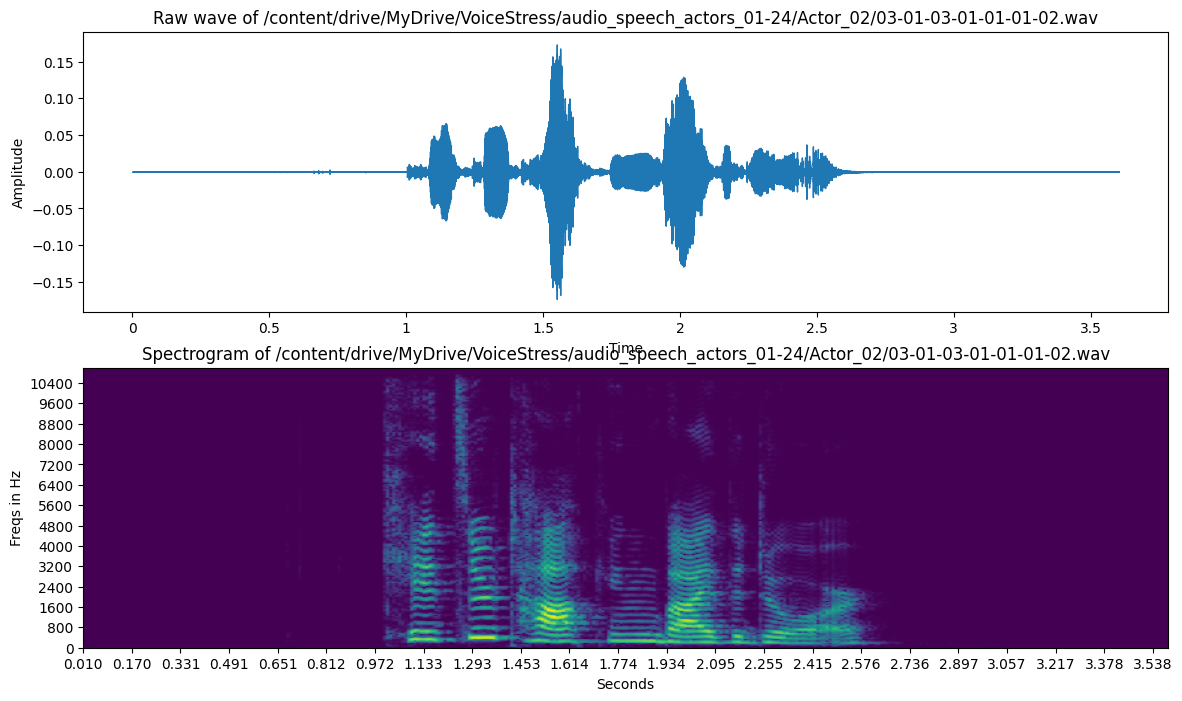

In [33]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveshow(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [42]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [44]:
# Silence trimmed Sound
ipd.Audio(trimmed, rate=sample_rate)

In [52]:
# Classes

label_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "neutral"
    elif data_df.emotion[i] == 2:
        lb = "positive"
    elif data_df.emotion[i] == 3:
        lb = "positive"
    elif data_df.emotion[i] == 4:
        lb = "negative"
    elif data_df.emotion[i] == 5:
        lb = "negative"
    elif data_df.emotion[i] == 6:
        lb = "negative"
    elif data_df.emotion[i] == 7:
        lb = "neutral"
    elif data_df.emotion[i] == 8:
        lb = "neutral"
    else:
        lb = "neutral"

    label_list.append(lb)

print(label_list)
data_df['label'] = label_list

['negative', 'positive', 'neutral', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'neutral', 'negative', 'negative', 'negative', 'negative', 'neutral', 'negative', 'positive', 'neutral', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'negative', 'negative', 'neutral', 'neutral', 'negative', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'neutral', 'positive', 'positive', 'positive', 'negative', 'neutral', 'neutral', 'p

In [53]:
# Function to plot the emotion distribution
def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

neutral     380
positive    380
negative    380
Name: label, dtype: int64


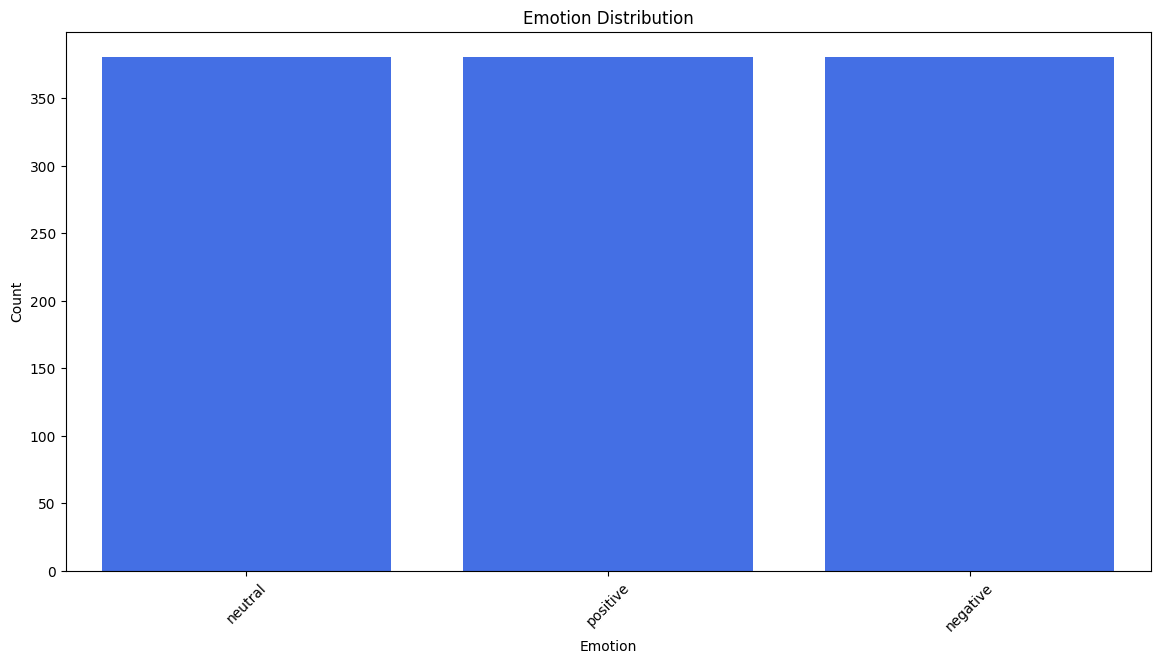

In [154]:
print(data_df["label"].value_counts())
plot_emotion_dist(data_df.label.value_counts(), "#2962FF", "Emotion Distribution")

In [155]:
neutral_data=data_df[data_df["label"]=="neutral"]
positive_data=data_df[data_df["label"]=="positive"]
negative_data=data_df[data_df["label"]=="negative"]

positive_data.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
380,/content/drive/MyDrive/VoiceStress/audio_speec...,1,15,male,1,0,1,2,positive
381,/content/drive/MyDrive/VoiceStress/audio_speec...,1,18,female,1,0,1,2,positive
382,/content/drive/MyDrive/VoiceStress/audio_speec...,1,5,male,0,1,1,3,positive
383,/content/drive/MyDrive/VoiceStress/audio_speec...,1,3,male,0,1,0,2,positive
384,/content/drive/MyDrive/VoiceStress/audio_speec...,1,15,male,1,1,0,3,positive


In [156]:
neutral_data=neutral_data.sample(n = 380)
positive_data=positive_data.sample(n = 380)
negative_data=negative_data.sample(n = 380)

In [157]:
len(negative_data)

380

In [158]:
data_df=pd.concat([neutral_data,positive_data,negative_data], axis=0)
data_df.head(25)

,path,source,actor,gender,intensity,statement,repetition,emotion,label
100,/content/drive/MyDrive/VoiceStress/audio_speec...,1,3,male,0,0,1,8,neutral
219,/content/drive/MyDrive/VoiceStress/audio_speec...,1,1,male,1,0,1,7,neutral
12,/content/drive/MyDrive/VoiceStress/audio_speec...,1,20,female,0,0,1,1,neutral
0,/content/drive/MyDrive/VoiceStress/audio_speec...,1,3,male,1,1,0,8,neutral
259,/content/drive/MyDrive/VoiceStress/audio_speec...,1,14,female,0,0,0,8,neutral
248,/content/drive/MyDrive/VoiceStress/audio_speec...,1,24,female,0,0,0,7,neutral
178,/content/drive/MyDrive/VoiceStress/audio_speec...,1,1,male,0,1,0,1,neutral
366,/content/drive/MyDrive/VoiceStress/audio_speec...,1,18,female,0,0,0,7,neutral
374,/content/drive/MyDrive/VoiceStress/audio_speec...,1,2,female,1,0,0,8,neutral
192,/content/drive/MyDrive/VoiceStress/audio_speec...,1,9,male,0,0,0,8,neutral


In [159]:
data_df.label.value_counts()

neutral     380
positive    380
negative    380
Name: label, dtype: int64

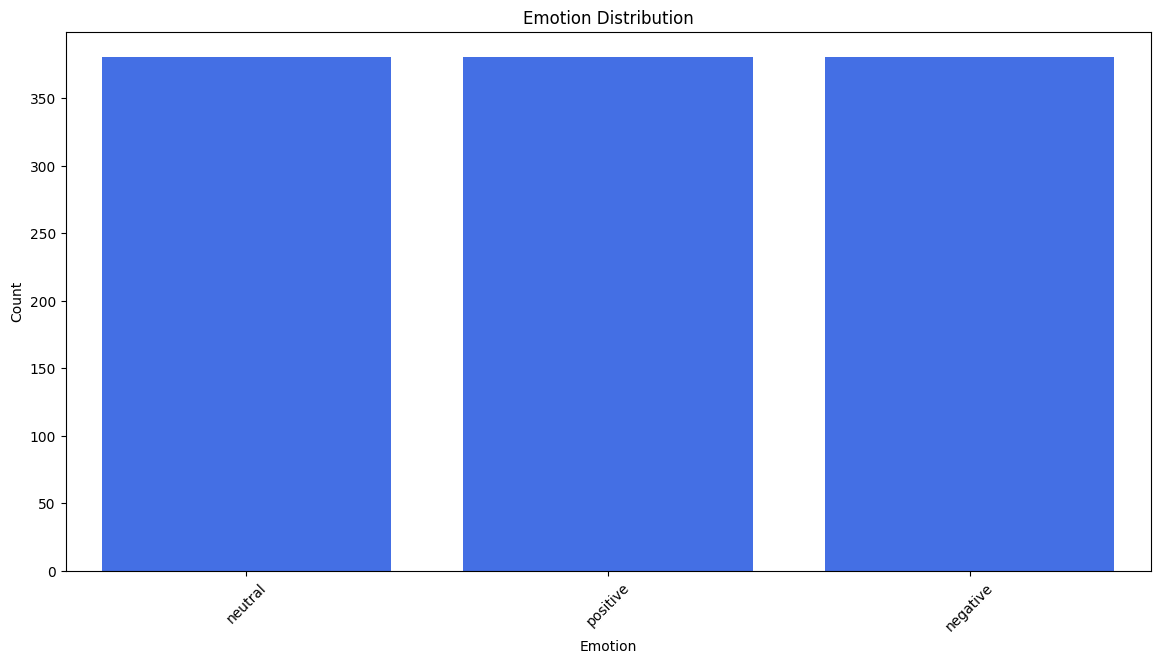

In [160]:
plot_emotion_dist(data_df.label.value_counts(), "#2962FF", "Emotion Distribution")

In [161]:
# Trim the silence voice
trimmed , index = librosa.effects.trim(samples, top_db=30)
trimmed, index

(array([-7.5163339e-06, -2.1580738e-05, -5.3294243e-06, ...,
         2.0110690e-06, -2.5624891e-07, -5.8238152e-07], dtype=float32),
 array([22016, 82432]))

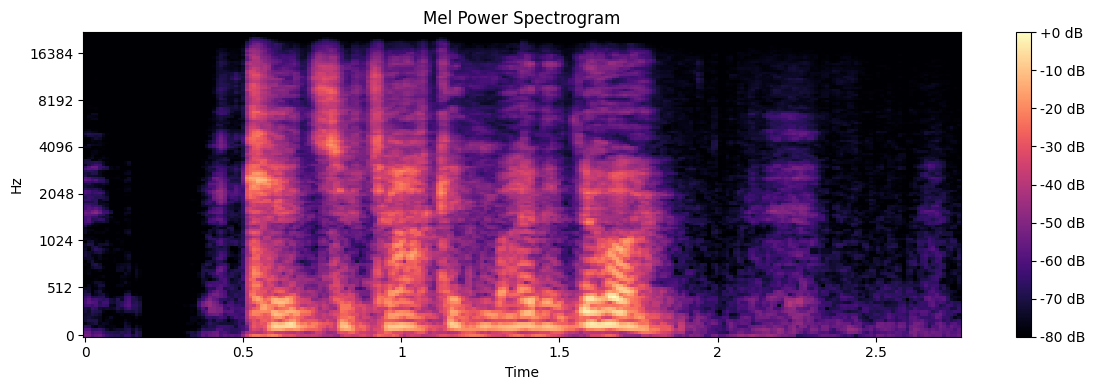

In [162]:
# Plotting None trimmed Mel Power Spectrogram
S = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB).
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel Power Spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()

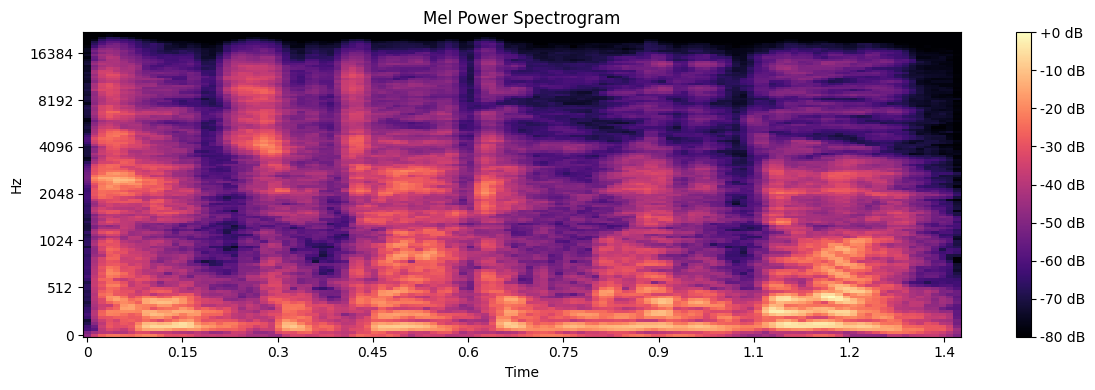

In [163]:
# Plotting Trimmed Mel Power Spectrogram
S = librosa.feature.melspectrogram(y=trimmed, sr=sample_rate, n_mels=128)

# Convert to log scale (dB).
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel Power Spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()

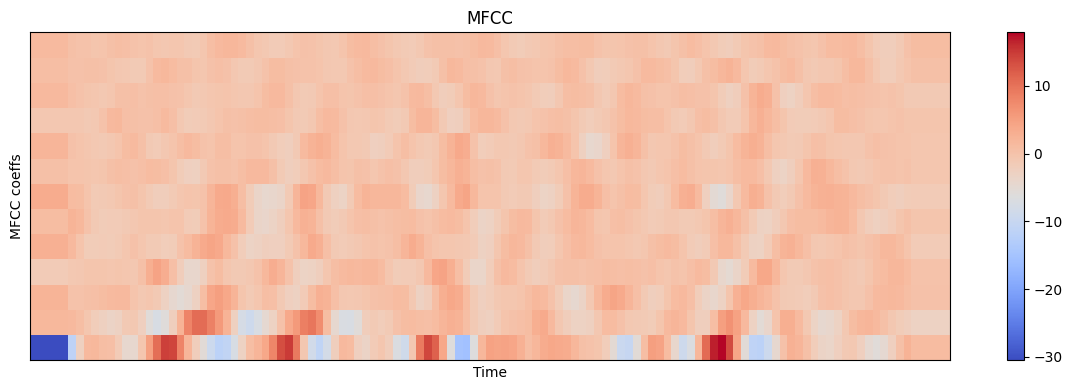

In [164]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [165]:
data_df=data_df.reset_index(drop=True)

In [166]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data_df))):
    samples, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    trimmed , index = librosa.effects.trim(samples, top_db=30)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=trimmed, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 1140/1140 [01:59<00:00,  9.58it/s]


In [167]:
data.head()

,feature
0,"[-48.720425, -40.544704, -38.50148, -38.834644..."
1,"[-40.17907, -39.07397, -40.704857, -37.21946, ..."
2,"[-67.32897, -52.168938, -46.202507, -45.454556..."
3,"[-29.750648, -27.53589, -30.259094, -32.490788..."
4,"[-64.59285, -58.571674, -51.13931, -48.137047,..."


In [168]:
trimmed_df = pd.DataFrame(data['feature'].values.tolist())
labels = data_df.label

trimmed_df

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-48.720425,-40.544704,-38.501480,-38.834644,-42.510239,-39.204849,-34.492962,-34.101620,-38.573147,-38.221375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-40.179070,-39.073971,-40.704857,-37.219460,-35.909664,-37.632935,-38.763245,-38.450222,-39.294987,-40.089260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-67.328972,-52.168938,-46.202507,-45.454556,-45.292912,-46.910030,-46.705696,-44.832901,-44.474403,-44.939713,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-29.750648,-27.535891,-30.259094,-32.490788,-31.987061,-31.539988,-32.773441,-34.106987,-33.651291,-33.340645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-64.592850,-58.571674,-51.139309,-48.137047,-48.432381,-50.205177,-48.266911,-48.119709,-48.066002,-46.509094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,-54.979607,-42.330788,-34.761429,-33.305466,-35.784821,-38.909752,-37.036381,-36.610371,-37.475491,-36.064598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1136,-33.615391,-21.733631,-20.886116,-24.650312,-24.835323,-25.009693,-25.878441,-28.279287,-28.895113,-29.237274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1137,-41.946701,-28.183949,-26.885212,-28.629566,-28.694105,-30.817617,-32.680138,-33.565475,-31.827579,-31.785021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1138,-46.670876,-39.081394,-38.073997,-37.995670,-37.275211,-37.224625,-33.250229,-32.851875,-35.216541,-38.040604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
trimmed_df = pd.concat([trimmed_df,labels], axis=1)
trimmed_df = trimmed_df.rename(index=str, columns={"0": "label"})

trimmed_df.shape

(1140, 260)

In [170]:
trimmed_df.isnull().sum().sum()

117082

In [171]:
trimmed_df = trimmed_df.fillna(0)
trimmed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-48.720425,-40.544704,-38.501480,-38.834644,-42.510239,-39.204849,-34.492962,-34.101620,-38.573147,-38.221375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
1,-40.179070,-39.073971,-40.704857,-37.219460,-35.909664,-37.632935,-38.763245,-38.450222,-39.294987,-40.089260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
2,-67.328972,-52.168938,-46.202507,-45.454556,-45.292912,-46.910030,-46.705696,-44.832901,-44.474403,-44.939713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
3,-29.750648,-27.535891,-30.259094,-32.490788,-31.987061,-31.539988,-32.773441,-34.106987,-33.651291,-33.340645,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
4,-64.592850,-58.571674,-51.139309,-48.137047,-48.432381,-50.205177,-48.266911,-48.119709,-48.066002,-46.509094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral


In [172]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)

def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 * (np.random.uniform())
    data_shifted = librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=pitch_change,
                                              bins_per_octave=bins_per_octave)
    return data

def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)

def speedNpitch(data):
    """
    Speed and Pitch Tuning.
    """
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

**Making Noise Added Dataframe**

In [208]:
samples, sample_rate = librosa.load(data_df.path[79], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
trimmed , index = librosa.effects.trim(samples, top_db=30)

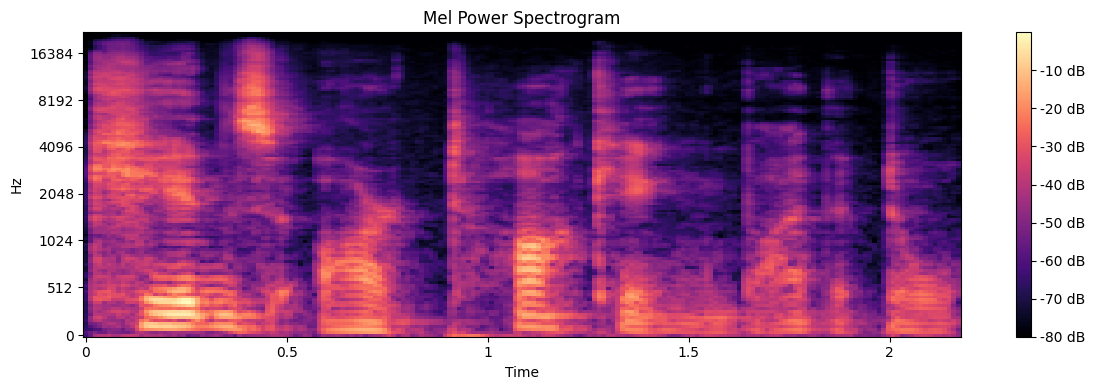

In [174]:
# Plotting Trimmed Mel Power Spectrogram
S = librosa.feature.melspectrogram(y=trimmed, sr=sample_rate, n_mels=128)

# Convert to log scale (dB).
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel Power Spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()

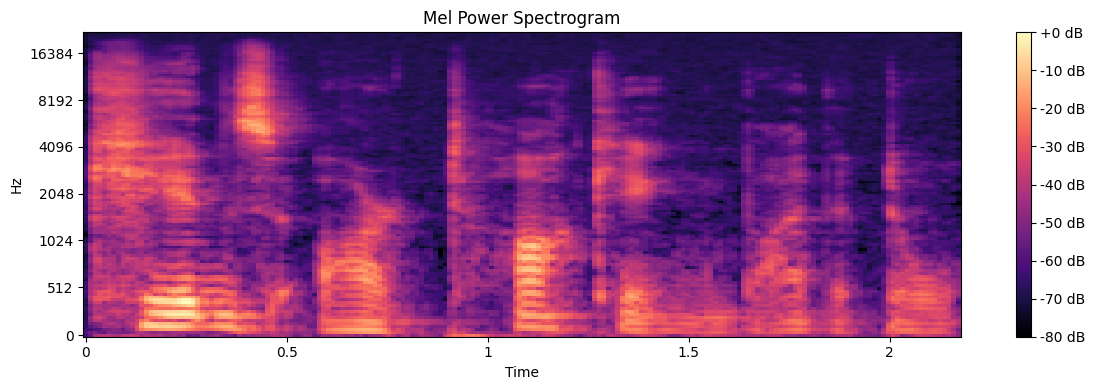

In [175]:
# Plotting Trimmed Noise Added Mel Power Spectrogram
X = noise(trimmed)
S = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128)
# Convert to log scale (dB).
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel Power Spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()

In [176]:
# Data Making (Noise Added)
NoiseAdded_df = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data_df))):
    samples, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    trimmed , index = librosa.effects.trim(samples, top_db=30)
    if data_df.label[i]:
        X = noise(trimmed)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        NoiseAdded_df.loc[i] = [feature, data_df.label[i]]

100%|██████████| 1140/1140 [02:02<00:00,  9.29it/s]


**Pitch Changed Dataframe**

In [177]:
samples, sample_rate = librosa.load(data_df.path[79], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
trimmed , index = librosa.effects.trim(samples, top_db=30)

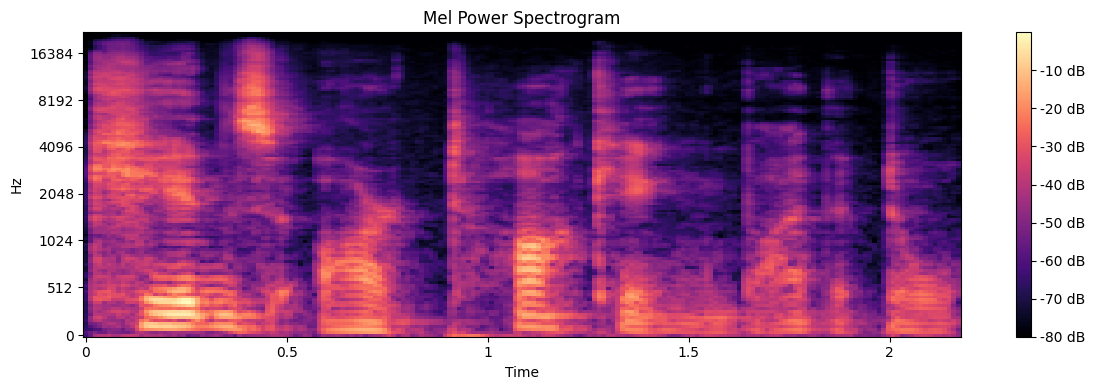

In [178]:
# Plotting Trimmed Mel Power Spectrogram
S = librosa.feature.melspectrogram(y=trimmed, sr=sample_rate, n_mels=128)

# Convert to log scale (dB).
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel Power Spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()

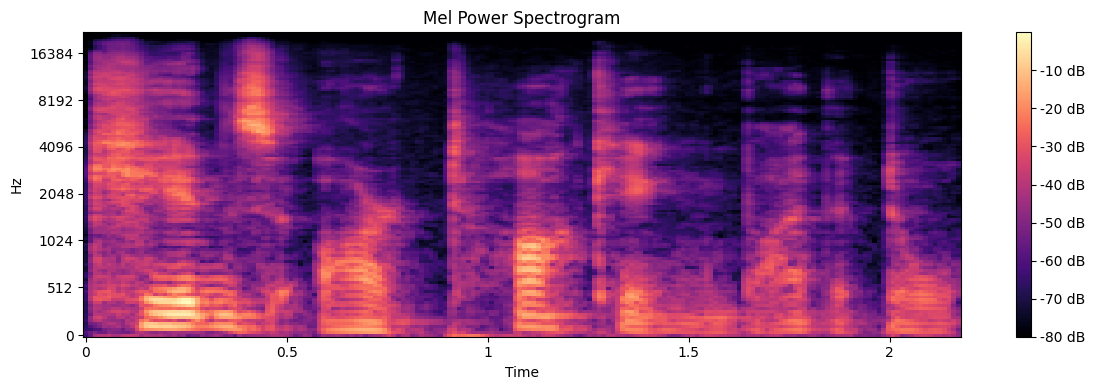

In [179]:
# Plotting Pitch Changed Mel Power Spectrogram
X = pitch(trimmed, sample_rate)
S = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128)
# Convert to log scale (dB).
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel Power Spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()

In [180]:
# Data Making (Pitch Changed)
PitchChanged_df = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data_df))):
    samples, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    trimmed , index = librosa.effects.trim(samples, top_db=30)
    if data_df.label[i]:
        X = pitch(trimmed, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        PitchChanged_df.loc[i] = [feature, data_df.label[i]]

100%|██████████| 1140/1140 [03:13<00:00,  5.90it/s]


In [181]:
len(NoiseAdded_df), len(PitchChanged_df)

(1140, 1140)

In [182]:
NoiseAdded_df = NoiseAdded_df.reset_index(drop=True)
PitchChanged_df = PitchChanged_df.reset_index(drop=True)

In [183]:
NoiseAdded_feat = pd.DataFrame(NoiseAdded_df['feature'].values.tolist())
labels = NoiseAdded_df.label
FinalizedNoiseAdded_df = pd.concat([NoiseAdded_feat,labels], axis=1)
FinalizedNoiseAdded_df = FinalizedNoiseAdded_df.rename(index=str, columns={"0": "label"})
FinalizedNoiseAdded_df = FinalizedNoiseAdded_df.fillna(0)
len(FinalizedNoiseAdded_df)

1140

In [184]:
FinalizedNoiseAdded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-44.920184,-38.866200,-37.132623,-38.424011,-41.343181,-39.885451,-33.109571,-32.354235,-37.531473,-38.424232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
1,-40.988402,-38.326353,-38.682083,-37.185295,-35.876472,-36.511682,-36.337117,-36.208705,-37.254804,-39.776928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
2,-61.003038,-50.202388,-46.391679,-45.274655,-44.578782,-45.993602,-46.354088,-44.313430,-43.965973,-44.471867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
3,-29.781314,-27.554947,-30.092104,-32.382330,-32.051316,-31.363368,-32.637901,-34.155090,-33.623568,-33.512794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
4,-64.535380,-58.500662,-51.173779,-48.096951,-48.341215,-50.432872,-48.459319,-48.274664,-48.171552,-46.507319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral


In [185]:
PitchChanged_feat = pd.DataFrame(PitchChanged_df['feature'].values.tolist())
labels = PitchChanged_df.label
FinalizedPitchChanged_df = pd.concat([PitchChanged_feat,labels], axis=1)
FinalizedPitchChanged_df = FinalizedPitchChanged_df.rename(index=str, columns={"0": "label"})
FinalizedPitchChanged_df = FinalizedPitchChanged_df.fillna(0)
len(FinalizedPitchChanged_df)

1140

In [186]:
FinalizedPitchChanged_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-48.720425,-40.544704,-38.501480,-38.834644,-42.510239,-39.204849,-34.492962,-34.101620,-38.573147,-38.221375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
1,-40.179070,-39.073971,-40.704857,-37.219460,-35.909664,-37.632935,-38.763245,-38.450222,-39.294987,-40.089260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
2,-67.328972,-52.168938,-46.202507,-45.454556,-45.292912,-46.910030,-46.705696,-44.832901,-44.474403,-44.939713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
3,-29.750648,-27.535891,-30.259094,-32.490788,-31.987061,-31.539988,-32.773441,-34.106987,-33.651291,-33.340645,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
4,-64.592850,-58.571674,-51.139309,-48.137047,-48.432381,-50.205177,-48.266911,-48.119709,-48.066002,-46.509094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral


In [187]:
# Combining the Proccessed data with original
combined_df = pd.concat([trimmed_df, FinalizedNoiseAdded_df, FinalizedPitchChanged_df], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-48.720425,-40.544704,-38.501480,-38.834644,-42.510239,-39.204849,-34.492962,-34.101620,-38.573147,-38.221375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
1,-40.179070,-39.073971,-40.704857,-37.219460,-35.909664,-37.632935,-38.763245,-38.450222,-39.294987,-40.089260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
2,-67.328972,-52.168938,-46.202507,-45.454556,-45.292912,-46.910030,-46.705696,-44.832901,-44.474403,-44.939713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
3,-29.750648,-27.535891,-30.259094,-32.490788,-31.987061,-31.539988,-32.773441,-34.106987,-33.651291,-33.340645,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
4,-64.592850,-58.571674,-51.139309,-48.137047,-48.432381,-50.205177,-48.266911,-48.119709,-48.066002,-46.509094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral


In [188]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3420 entries, 0 to 3419
Columns: 260 entries, 0 to label
dtypes: float64(259), object(1)
memory usage: 6.8+ MB


In [189]:
#  Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=4)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [190]:
y_train.value_counts()

neutral     912
positive    912
negative    912
Name: label, dtype: int64

In [191]:
y_test.value_counts()

positive    228
negative    228
neutral     228
Name: label, dtype: int64

In [192]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

import pickle
pickle.dump(lb, open("lb.sav", 'wb'))

In [193]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [194]:
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [195]:
X_train.shape

(2736, 259)

In [196]:
model = Sequential()

model.add(Conv1D(64, 8, padding='same', input_shape=(X_train.shape[1], 1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(BatchNormalization())

model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(BatchNormalization())

model.add(Conv1D(256, 8, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(3))
model.add(Activation('softmax'))

In [197]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 259, 64)           576       
                                                                 
 activation_6 (Activation)   (None, 259, 64)           0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 64, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 64, 128)           65664     
                                                                 
 activation_7 (Activation)   (None, 64, 128)          

In [198]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [199]:
# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
mcp_save = ModelCheckpoint('/content/drive/MyDrive/VoiceStress/Model/model_last.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=100,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Epoch 1/100
171/171 [==============================] - 5s 9ms/step - loss: 1.2116 - accuracy: 0.3586 - val_loss: 1.0808 - val_accuracy: 0.3977 - lr: 0.0010
Epoch 2/100
171/171 [==============================] - 2s 11ms/step - loss: 1.1066 - accuracy: 0.3673 - val_loss: 1.0552 - val_accuracy: 0.4006 - lr: 0.0010
Epoch 3/100
171/171 [==============================] - 2s 10ms/step - loss: 1.1023 - accuracy: 0.3783 - val_loss: 1.0282 - val_accuracy: 0.4649 - lr: 0.0010
Epoch 4/100
171/171 [==============================] - 1s 8ms/step - loss: 1.0741 - accuracy: 0.4075 - val_loss: 1.0102 - val_accuracy: 0.4371 - lr: 0.0010
Epoch 5/100
171/171 [==============================] - 1s 7ms/step - loss: 1.0551 - accuracy: 0.4302 - val_loss: 0.9875 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 6/100
171/171 [==============================] - 1s 7ms/step - loss: 1.0619 - accuracy: 0.3969 - val_loss: 1.0195 - val_accuracy: 0.4488 - lr: 0.0010
Epoch 7/100
171/171 [==============================] - 1s 7ms/

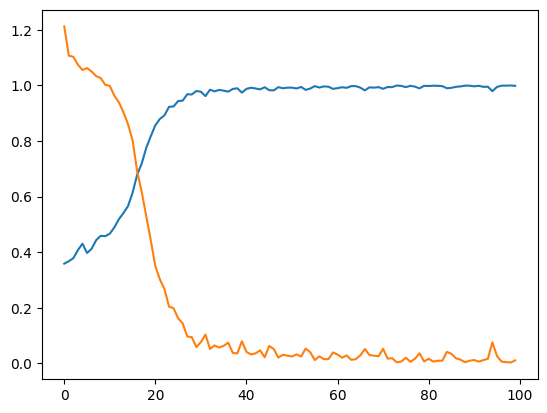

In [200]:
import matplotlib.pyplot as plt

accuracy = cnnhistory.history['accuracy']
loss = cnnhistory.history['loss']

epochs = range(len(accuracy))

plt.plot(epochs,accuracy)
plt.plot(epochs, loss)
plt.show()

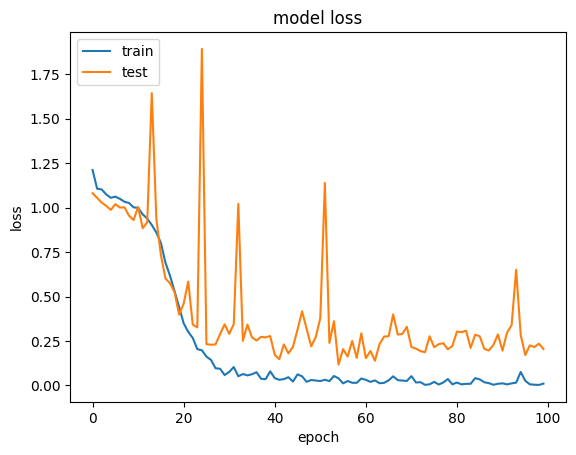

In [201]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [202]:
import time
start_time = time.perf_counter()
y_pred=model.predict(x_testcnn)
pred_category=np.array([])
for i in range(y_pred.shape[0]):
    pred_category=np.append(pred_category, [y_pred[i].argmax(axis=0)])
flat_category = pred_category.astype(int).flatten()
end_time=time.perf_counter()
execution_time = end_time - start_time
print(f"Total execution time is: {execution_time}, per record execution time: {execution_time/y_pred.shape[0]}")

22/22 [==============================] - 0s 4ms/step
Total execution time is: 0.4321282319997408, per record execution time: 0.0006317664210522527


In [203]:
y_test_category=np.array([])
for i in range(y_test.shape[0]):
    y_test_category=np.append(y_test_category, [y_test[i].argmax(axis=0)])
y_test_flat_category = y_test_category.astype(int).flatten()

In [204]:
from sklearn.metrics import classification_report

print(classification_report(y_test_flat_category, flat_category, target_names=lb.inverse_transform([0,1,2])))

              precision    recall  f1-score   support

    negative       0.98      0.98      0.98       228
     neutral       0.96      0.96      0.96       228
    positive       0.97      0.97      0.97       228

    accuracy                           0.97       684
   macro avg       0.97      0.97      0.97       684
weighted avg       0.97      0.97      0.97       684



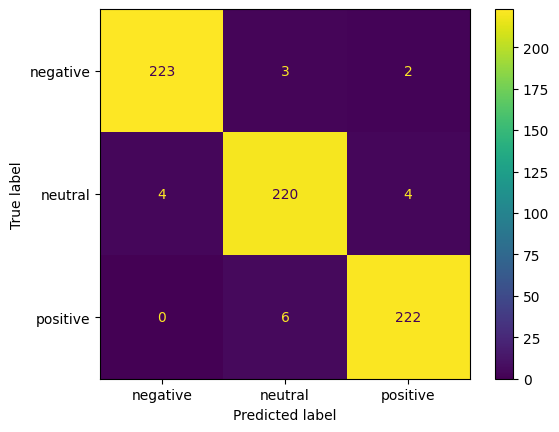

In [205]:
from sklearn.metrics import ConfusionMatrixDisplay


conf_mat=confusion_matrix(lb.inverse_transform(y_test_flat_category), lb.inverse_transform(flat_category), labels=lb.inverse_transform([0,1,2]))
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = lb.inverse_transform([0,1,2]))

cm_display.plot()
plt.show()

In [206]:
len(data_df)

1140

In [209]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data_df))):
    samples, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    trimmed , index = librosa.effects.trim(samples, top_db=30)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=trimmed, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]

test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 1140/1140 [01:57<00:00,  9.73it/s]


In [216]:
preds =model.predict(x_testcnn,
                         batch_size=16,
                         verbose=1)

43/43 [==============================] - 0s 3ms/step


In [217]:
preds

array([[5.3108398e-08, 7.1913031e-10, 1.0000000e+00],
       [2.5829197e-09, 2.7960548e-08, 1.0000000e+00],
       [1.0000000e+00, 1.6640361e-09, 3.9879797e-09],
       ...,
       [1.4186187e-06, 9.9999058e-01, 7.9435777e-06],
       [1.0000000e+00, 1.4546813e-14, 2.5322271e-13],
       [1.0000000e+00, 9.3327106e-09, 1.8961501e-08]], dtype=float32)

In [218]:
preds=preds.argmax(axis=1)
print(preds)

[2 2 0 0 2 0 0 0 0 0 2 1 0 1 2 0 2 2 2 1 2 1 0 0 1 0 0 0 2 0 2 2 2 0 1 1 1
 0 2 1 0 0 2 2 0 2 2 0 1 2 1 0 0 0 2 0 1 1 0 2 1 1 0 0 1 2 2 1 2 0 2 1 1 2
 1 0 0 0 1 1 1 0 1 2 0 2 1 2 0 2 0 0 0 0 2 0 1 0 1 0 0 0 0 1 2 2 1 1 2 2 1
 1 1 0 0 2 0 2 1 0 1 2 0 1 2 2 2 1 2 2 2 1 1 2 2 2 1 0 0 1 1 2 0 2 0 0 2 1
 2 1 1 2 2 2 1 2 0 2 1 0 1 0 1 0 1 1 0 1 0 2 1 1 2 1 2 0 2 1 0 1 1 1 1 1 0
 2 2 2 0 0 0 0 2 1 1 2 1 2 0 1 1 0 2 1 1 2 0 2 0 2 0 1 2 0 1 2 1 1 1 1 0 2
 1 1 2 2 1 1 2 2 1 0 1 0 0 0 2 1 1 0 2 1 1 0 1 1 2 1 0 2 0 2 2 0 2 0 0 1 0
 1 2 2 1 1 0 1 2 2 1 2 1 1 2 0 2 2 1 0 0 1 0 0 0 2 2 0 0 0 0 0 2 1 0 0 0 2
 1 1 0 0 1 2 2 1 2 1 1 1 0 1 2 1 1 1 2 1 0 1 1 0 2 2 0 0 0 1 2 1 1 1 2 1 1
 2 0 0 1 0 0 1 0 1 0 2 2 0 1 1 1 1 2 1 0 1 1 2 0 1 1 1 2 1 2 1 0 0 0 1 2 1
 2 0 2 2 2 2 1 1 2 2 1 0 0 1 0 0 0 2 2 0 0 0 1 2 2 2 0 2 0 1 0 0 2 1 1 2 0
 0 2 0 1 2 2 2 2 0 2 0 2 2 0 2 2 1 1 0 1 1 1 2 2 2 0 2 1 1 2 1 2 0 0 2 0 1
 1 2 1 2 1 2 2 2 0 2 2 0 0 0 1 0 1 1 2 2 0 0 1 1 2 1 1 0 2 0 1 2 0 1 2 2 0
 0 0 1 0 1 0 1 0 1 2 0 1 

In [219]:
preds = preds.astype(int).flatten()
print(preds)

[2 2 0 0 2 0 0 0 0 0 2 1 0 1 2 0 2 2 2 1 2 1 0 0 1 0 0 0 2 0 2 2 2 0 1 1 1
 0 2 1 0 0 2 2 0 2 2 0 1 2 1 0 0 0 2 0 1 1 0 2 1 1 0 0 1 2 2 1 2 0 2 1 1 2
 1 0 0 0 1 1 1 0 1 2 0 2 1 2 0 2 0 0 0 0 2 0 1 0 1 0 0 0 0 1 2 2 1 1 2 2 1
 1 1 0 0 2 0 2 1 0 1 2 0 1 2 2 2 1 2 2 2 1 1 2 2 2 1 0 0 1 1 2 0 2 0 0 2 1
 2 1 1 2 2 2 1 2 0 2 1 0 1 0 1 0 1 1 0 1 0 2 1 1 2 1 2 0 2 1 0 1 1 1 1 1 0
 2 2 2 0 0 0 0 2 1 1 2 1 2 0 1 1 0 2 1 1 2 0 2 0 2 0 1 2 0 1 2 1 1 1 1 0 2
 1 1 2 2 1 1 2 2 1 0 1 0 0 0 2 1 1 0 2 1 1 0 1 1 2 1 0 2 0 2 2 0 2 0 0 1 0
 1 2 2 1 1 0 1 2 2 1 2 1 1 2 0 2 2 1 0 0 1 0 0 0 2 2 0 0 0 0 0 2 1 0 0 0 2
 1 1 0 0 1 2 2 1 2 1 1 1 0 1 2 1 1 1 2 1 0 1 1 0 2 2 0 0 0 1 2 1 1 1 2 1 1
 2 0 0 1 0 0 1 0 1 0 2 2 0 1 1 1 1 2 1 0 1 1 2 0 1 1 1 2 1 2 1 0 0 0 1 2 1
 2 0 2 2 2 2 1 1 2 2 1 0 0 1 0 0 0 2 2 0 0 0 1 2 2 2 0 2 0 1 0 0 2 1 1 2 0
 0 2 0 1 2 2 2 2 0 2 0 2 2 0 2 2 1 1 0 1 1 1 2 2 2 0 2 1 1 2 1 2 0 0 2 0 1
 1 2 1 2 1 2 2 2 0 2 2 0 0 0 1 0 1 1 2 2 0 0 1 1 2 1 1 0 2 0 1 2 0 1 2 2 0
 0 0 1 0 1 0 1 0 1 2 0 1 

In [220]:
predictions = (lb.inverse_transform((preds)))

In [221]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,positive
1,positive
2,negative
3,negative
4,positive
5,negative
6,negative
7,negative
8,negative
9,negative


In [223]:
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((actual)))

In [229]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,positive
1,positive
2,negative
3,negative
4,positive
5,negative
6,neutral
7,negative
8,negative
9,negative


In [230]:
finaldf = actualdf.join(preddf)

In [231]:
finaldf[40:60]

,actualvalues,predictedvalues
40,negative,negative
41,negative,negative
42,positive,positive
43,positive,positive
44,negative,negative
45,positive,positive
46,positive,positive
47,negative,negative
48,neutral,neutral
49,positive,positive


In [232]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
negative,228
neutral,228
positive,228


In [233]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
negative,227
neutral,229
positive,228
